In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

sys.path.insert(0, '../kinetic_analysis')
from kinetic_function import (single_track_analysis,
                              generate_track
                             )

In [2]:
prot_aa_size = {
    "32xsuntag": 796,  #768/32=24 , left 28
    "linker": 4,
    "twist": 490,
    "ilp4": 134,
    "snail": 390,
    "very_long_prot":2000, 
}

In [3]:
path_save = "/home/u2175049/Documents/Code/KineticAnalysis/notebook/figures/"
path = "/mnt/sda1/Sophie/2-KineticAnalysisData/2-Datas/05-Modelling/06_RetentionTime/"

In [5]:
first_time = True
for rt in [0, 0.1, 1, 10, 50, 100]:
    for i in range(100):
        x_global, y_global, y_start_prot = generate_track(prot_length = prot_aa_size["snail"], 
                                                          suntag_length = prot_aa_size["32xsuntag"],
                                                          nb_suntag=32, 
                                                          fluo_one_suntag=4, 
                                                          translation_rate=24, 
                                                          binding_rate=0.05,
                                                          retention_time=rt,
                                                          suntag_pos="begin",
                                                          step = 0.1,
                                                          length=6000)
        if first_time:
            datas = pd.DataFrame({"FRAME":x_global,
                                  "MEAN_INTENSITY_CH1":y_global,
                                  "TRACK_ID" : i,
                                  "RETENTION_TIME":rt,
                                 })
            first_time = False
        else:
            datas = pd.concat([datas, 
                               pd.DataFrame({"FRAME":x_global,
                                              "MEAN_INTENSITY_CH1":y_global,
                                              "TRACK_ID" : i,
                                             "RETENTION_TIME":rt,
                                 })], ignore_index=True)


datas.to_csv(os.path.join(path, "datas_retention_time.csv"))

In [6]:
datas = pd.read_csv(os.path.join(path, "datas_retention_time.csv"), index_col="Unnamed: 0")

In [8]:
first_time = True
dt = 3
t = dt/0.1
for rt in [0, 0.1, 1, 10, 50, 100]:
    prot_length = prot_aa_size["32xsuntag"]+prot_aa_size["snail"]
    for i in range(100):
        datas2 =datas[(datas["TRACK_ID"]==i) & (datas["RETENTION_TIME"]==rt)][::int(t)]
        (x, 
        y, 
        x_auto, 
        y_auto, 
        elongation_r, 
        translation_init_r,
        perr) = single_track_analysis(datas2,
                                     i, 
                                     delta_t = dt,
                                     protein_size=prot_length,
                                     normalise_intensity=1,
                                     normalise_auto=True,
                                     mm=None,
                                     lowpass_=False,
                                     cutoff=100,
                                     rtol=1e-1,
                                     method="linear",
                                     force_analysis=True,
                                     first_dot=True,
                                     simulation=True)
        if first_time:
            results = pd.DataFrame({"elongation_r":elongation_r, 
                                    "init_translation_r":translation_init_r, 
                                    "dt":dt,
                                   "id":i,
                                   "retention_time":rt},
                                  index=[0])
            first_time = False
        
        else:
            results = pd.concat([results, 
                            pd.DataFrame({"elongation_r":elongation_r, 
                                          "init_translation_r":translation_init_r, 
                                          "dt":dt, 
                                          "id":i,
                                         "retention_time":rt}, index=[0])
                            ], ignore_index=True)
results.to_csv(os.path.join(path, "results_retention_time.csv"))

In [9]:
results.groupby(by='retention_time')[['elongation_r','init_translation_r']].mean()

,elongation_r,init_translation_r
retention_time,,
0.0,20.181470,27.617983
0.1,20.559563,27.354248
1.0,20.087276,27.779205
10.0,17.097201,26.775307
50.0,10.789139,24.991172
100.0,6.619856,27.327701


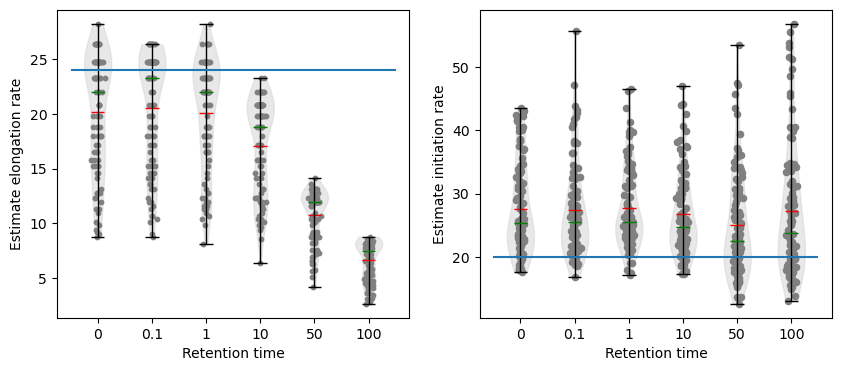

In [10]:
fig, ax = plt.subplots(1,2)


violin = ax[0].violinplot(dataset = [results[results.retention_time == i]["elongation_r"].values 
                                     for i in [0, 0.1, 1, 10, 50, 100]
                          ],showmeans=True,
      showmedians=True)

for pc in violin["bodies"]:
    pc.set_facecolor("lightgrey")
    pc.set_edgecolor("lightgrey")
    pc.set_alpha(0.5)

colors = ["black", "black", "black", "red", "green"]
i=0
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin[partname]
    vp.set_edgecolor(colors[i])
    vp.set_linewidth(1)
    i+=1
    
# results.boxplot(['init_translation_r'] , 
#                by='retention_time', 
#                grid=False, 
#                ax = ax[1],
#                rot=90,
#                boxprops=dict(linestyle='-', linewidth=1.5, color="black"),
#                medianprops=dict(linestyle='-', linewidth=1.5, color="red"),
#                )

violin = ax[1].violinplot(dataset = [results[results.retention_time == i]["init_translation_r"].values 
                                     for i in [0, 0.1, 1, 10, 50, 100]
                                    ], showmeans=True,
      showmedians=True)


for pc in violin["bodies"]:
    pc.set_facecolor("lightgrey")
    pc.set_edgecolor("lightgrey")
    pc.set_alpha(0.5)

colors = ["black", "black", "black", "red", "green"]
i=0
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin[partname]
    vp.set_edgecolor(colors[i])
    vp.set_linewidth(1)
    i+=1
    
group = 'retention_time'
column = 'elongation_r'
grouped = results.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
clevels = np.linspace(0., 1., len(grouped))
for x, val, clevel in zip(xs, vals, clevels):
    ax[0].scatter(x, val, c='grey', alpha=1, s=10)
    
group = 'retention_time'
column = 'init_translation_r'
grouped = results.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
clevels = np.linspace(0., 1., len(grouped))
for x, val, clevel in zip(xs, vals, clevels):
    ax[1].scatter(x, val, c='grey', alpha=1, s=20)
    
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Retention time')
# set style for the axes
labels = [0, 0.1, 1, 10, 50, 100]
for a in ax:
    set_axis_style(a, labels)

ax[0].set_ylabel("Estimate elongation rate")
ax[1].set_ylabel("Estimate initiation rate")    

# ax[1].set_ylim(0,250)
ax[0].hlines(24, 0.5, 6.5)
ax[1].hlines(1/0.05, 0.5, 6.5)
fig.set_size_inches((10,4))
# fig.savefig(os.path.join(path_save, "results_retention_time_boxplot_original.eps"), dpi=300)

Text(0, 0.5, 'Estimate elongation rate')

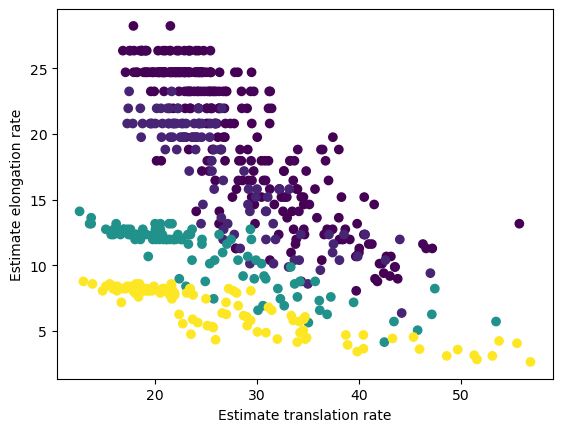

In [13]:
fig, ax = plt.subplots()
ax.scatter(results["init_translation_r"], results["elongation_r"], c=results["retention_time"])
ax.set_xlabel("Estimate translation rate")
ax.set_ylabel("Estimate elongation rate")

In [14]:
from scipy.stats import bootstrap

d = (results[results.retention_time == 10]["elongation_r"].to_numpy(),)
bootstrap_ci = bootstrap(d,
                          np.mean, 
                          confidence_level=0.95,
                          method="percentile"
                         )
bootstrap_ci.confidence_interval

ConfidenceInterval(low=16.231984531996467, high=17.923920964475606)

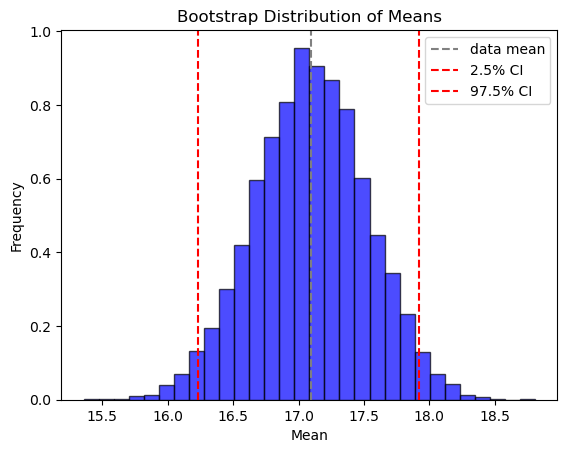

ConfidenceInterval(low=16.231984531996467, high=17.923920964475606)
Bootstrap Mean Estimate: 	17.094302879774496
Bootstrap Median Estimate: 	17.093986349439643
Bootstrap Standard Error: 	0.42891003886702295
Mean: 	17.0972013895439
Bootstrap Bias: -0.002898509769405422


In [15]:
import matplotlib.pyplot as plt

plt.hist(bootstrap_ci.bootstrap_distribution, density=True, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Bootstrap Distribution of Means')
plt.xlabel('Mean')
plt.ylabel('Frequency')
plt.axvline(np.mean(d)  , color='grey', linestyle='dashed', label='data mean')
plt.axvline(bootstrap_ci.confidence_interval.low, color='red', linestyle='dashed', label='2.5% CI')
plt.axvline(bootstrap_ci.confidence_interval.high, color='red', linestyle='dashed', label='97.5% CI')
plt.legend()
plt.show()

print(bootstrap_ci.confidence_interval)
# calculate central tendency
mean_estimate = np.mean(bootstrap_ci.bootstrap_distribution)
median_estimate = np.median(bootstrap_ci.bootstrap_distribution)
print(f"Bootstrap Mean Estimate: \t{mean_estimate}")
print(f"Bootstrap Median Estimate: \t{median_estimate}")

# measure variability
standard_error = np.std(bootstrap_ci.bootstrap_distribution)
print(f"Bootstrap Standard Error: \t{standard_error}")

# Assess bias
original_statistic = np.mean(d)  
print(f"Mean: \t{original_statistic}")
bias = np.mean(bootstrap_ci.bootstrap_distribution) - original_statistic
print(f"Bootstrap Bias: {bias}")



In [16]:
result_group = results.groupby(by='retention_time')[['elongation_r','init_translation_r']].mean()
result_group

,elongation_r,init_translation_r
retention_time,,
0.0,20.181470,27.617983
0.1,20.559563,27.354248
1.0,20.087276,27.779205
10.0,17.097201,26.775307
50.0,10.789139,24.991172
100.0,6.619856,27.327701


In [18]:
result_group["ratio"] = 100*result_group["elongation_r"]/24
result_group

,elongation_r,init_translation_r,ratio
retention_time,,,
0.0,20.181470,27.617983,84.089460
0.1,20.559563,27.354248,85.664845
1.0,20.087276,27.779205,83.696985
10.0,17.097201,26.775307,71.238339
50.0,10.789139,24.991172,44.954744
100.0,6.619856,27.327701,27.582734


In [15]:
groupby_datas = pd.DataFrame(datas.groupby(["TRACK_ID", "RETENTION_TIME"]).mean()["MEAN_INTENSITY_CH1"])
groupby_datas["RETENTION_TIME"] = groupby_datas.index.get_level_values("RETENTION_TIME")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


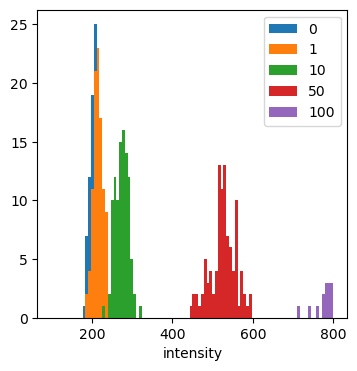

In [16]:
fig, ax = plt.subplots()
_=ax.hist(groupby_datas[groupby_datas.index.get_level_values("RETENTION_TIME").isin([0])]["MEAN_INTENSITY_CH1"].to_numpy(), 
          bins=100, 
          range=[100,800],
         label="0")
_=ax.hist(groupby_datas[groupby_datas.index.get_level_values("RETENTION_TIME").isin([1.0])]["MEAN_INTENSITY_CH1"].to_numpy(),
          bins=100, 
          range=[100,800],
         label="1")

_=ax.hist(groupby_datas[groupby_datas.index.get_level_values("RETENTION_TIME").isin([10.0])]["MEAN_INTENSITY_CH1"].to_numpy(),
          bins=100, 
          range=[100,800],
         label="10")
_=ax.hist(groupby_datas[groupby_datas.index.get_level_values("RETENTION_TIME").isin([50.0])]["MEAN_INTENSITY_CH1"].to_numpy(),
          bins=100, 
          range=[100,800],
         label="50")
_=ax.hist(groupby_datas[groupby_datas.index.get_level_values("RETENTION_TIME").isin([100.0])]["MEAN_INTENSITY_CH1"].to_numpy(),
          bins=100, 
          range=[100,800],
         label="100")
ax.legend()
ax.set_xlabel("intensity")

fig.set_size_inches((4,4))
fig.savefig(os.path.join(path_save, "results_retention_time_hist.eps"), dpi=300)

In [40]:
path = "/mnt/sda1/Sophie/2-KineticAnalysisData/2-Datas/04-Pierre_test_dt/tracking LLS 04_24/"


datas = pd.read_csv(os.path.join(path, "Experiment 512 export.csv"), sep=None, engine="python")
# if len(datas.columns)==1:
#     datas = pd.read_csv(os.path.join(path, "Experiment 512 export.csv"), sep=';')
    
    